In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
filename = "NanoAOD/NMSSM_XYH_YToHH_6b_MX_700_MY_400_accstudies_500k_Jul2021.root"
tree = Tree(filename)
preselection = Selection(tree,cuts={"njetcut":6},tag="preselection")
sixb_in_preselection = preselection.nsixb_selected == 6
print(preselection)
baseline = Selection(tree,mask=sixb_in_preselection,include=preselection,tag="baseline")
print(baseline)

--- all preselection / pt ---
Event Efficiency:   0.74
Selected Purity(6): 0.29
Passed Jet S/T:     0.69
Passed Jet MR:      0.40
Passed Jet Eff:     0.95
--- all baseline / pt ---
Event Efficiency:   0.29
Selected Purity(6): 1.00
Passed Jet S/T:     0.79
Passed Jet MR:      0.33
Passed Jet Eff:     1.00


In [3]:
ptinfo = dict(cutkey="ptcut",cutlist=range(20,120,20),tag="jet{cut}pt",cutlabels=range(20,120,20))
btaginfo = dict(cutkey="btagcut",cutlist=jet_btagWP,tag="{cut} btag",cutlabels=wplabels)

def multistep_signal_selection(previous=None,include=baseline):
    remaining = Selection(tree,previous=previous,include=include,tag="remaining")
    jets_ordered_study(remaining,njets=1,subset="passed")
    ptselection = step_signal_selection(remaining,**ptinfo)
    signaljet = step_signal_selection(ptselection,njets=1,**btaginfo)
    return signaljet

In [4]:
def step_signal_selection(selection,cutkey=None,cutlist=None,tag=None,cutlabels=None,njets=-1,optimize="jet_sovert"):
    print(f"--- starting {cutkey} optimization ---")
    
    if cutlabels is None: cutlabels = list(cutlist)
    if selection.tag and selection.tag != "remaining": tag = f"{tag} {selection.tag}"
    
    cut_selections = [ 
        selection.chosen_jets(cuts={"njetcut":1,cutkey:cut},njets=njets,tag=tag.format(cut=cutlabels[i]))
        for i,cut in enumerate(cutlist)
    ]
    cut_scores = [ cut_selection.score() for cut_selection in cut_selections ]
    compare_scores_study(cut_scores,cutlabels,cutkey,values=["efficiency",optimize])
    
    imax = np.argmax([ getattr(score,optimize) for score in cut_scores ])
    cut_selection = cut_selections[imax]
    print(f"--- optimized {cutkey} selection ---")
    jets_ordered_study(cut_selection,njets=1,subset="passed")
    return cut_selection

In [5]:
def plot_2d_wp_scores(scores,score,xinfo=None,yinfo=None,vmin=None,vmax=None,clim=None,figax=None):
    if figax is None: figax = plt.subplots()
    fig,ax = figax
    alpha = np.vectorize(lambda a:1)(scores)
    if vmin: alpha = alpha * np.where(scores > vmin,1,0)
    if vmax: alpha = alpha * np.where(scores < vmax,1,0)
    
    im = ax.imshow(scores*alpha,origin='lower',clim=clim)
    ax.set_title(score)
    if xinfo:
        ax.set_xlabel(xinfo['cutkey'])
        ax.set_xticks(range(len(xinfo['cutlabels'])))
        ax.set_xticklabels(xinfo['cutlabels'])
        
    if yinfo:
        ax.set_ylabel(yinfo['cutkey'])
        ax.set_yticks(range(len(yinfo['cutlabels'])))
        ax.set_yticklabels(yinfo['cutlabels'])
    labels = np.vectorize(lambda a:f"{a:0.2f}")(scores)
    for i,ylabels in enumerate(labels):
        for j,xlabel in enumerate(ylabels):
            ax.text(j,i, xlabel,ha='center',va='center')
        
    return im

In [6]:
def signal_2d_wp(remaining):
    selection_array = np.array(())
    
    schemes = []
    for i,ptcut in enumerate(ptinfo["cutlist"]):
        for j,btagcut in enumerate(btaginfo["cutlist"]):
            schemes.append( (i,ptcut,j,btagcut) )
            
    for i,ptcut,j,btagcut in tqdm(schemes):
        selection = remaining.chosen_jets(cuts=dict(njetcut=1,ptcut=ptcut,btagcut=btagcut),njets=1,tag=f"{btaginfo['cutlabels'][j]} btag jet{ptcut}pt")
        selection_array = np.append(selection_array,selection)
    selection_array = selection_array.reshape((len(ptinfo["cutlist"]),len(btaginfo["cutlist"])))
    return selection_array

In [7]:
def wp_2d_scores(wp_selections,saveas=None):
    wp_scores = np.vectorize(lambda a:a.score())(wp_selections)
    fig,axs = plt.subplots(nrows=1,ncols=5,figsize=(16,5),sharey=True,constrained_layout=True)

    efficiency = np.vectorize(lambda a:a.efficiency)(wp_scores)
    purity =     np.vectorize(lambda a:a.purity)(wp_scores)
    jet_sovert = np.vectorize(lambda a:a.jet_sovert)(wp_scores)
    jet_misstr = np.vectorize(lambda a:1-a.jet_misstr)(wp_scores)
    avg = np.mean([efficiency,purity,jet_sovert,jet_misstr],axis=0)

    im = plot_2d_wp_scores(efficiency,"efficiency",xinfo=btaginfo,yinfo=ptinfo,figax=(fig,axs[0]))
    im = plot_2d_wp_scores(purity,"purity",xinfo=btaginfo,clim=im.properties()['clim'],figax=(fig,axs[1]))
    im = plot_2d_wp_scores(jet_sovert,"jet_sovert",xinfo=btaginfo,clim=im.properties()['clim'],figax=(fig,axs[2]))
    im = plot_2d_wp_scores(jet_misstr,"1-jet_misstr",xinfo=btaginfo,clim=im.properties()['clim'],figax=(fig,axs[3]))
    im = plot_2d_wp_scores(avg,"avg",xinfo=btaginfo,clim=im.properties()['clim'],figax=(fig,axs[4]))

    fig.colorbar(im,ax=axs.ravel().tolist())
    
    if saveas: save_fig(fig,"wp_2d",saveas)
    plt.show()

# First Signal Jet

In [8]:
first_remaining = Selection(tree,include=baseline,tag="remaining")

In [9]:
# first_wp_array = signal_2d_wp(first_remaining)

In [10]:
# wp_2d_scores(first_wp_array,saveas="first_wp")

In [11]:
# first_signaljet = first_wp_array[1,3]
first_signaljet = first_remaining.chosen_jets(cuts=dict(njetcut=1,ptcut=60,btagcut=jet_btagWP[tightWP]),njets=1,tag="tight btag jet60pt")

# Second Signal Jet

In [12]:
second_remaining = Selection(tree,previous=first_signaljet,include=baseline,tag="remaining")

In [13]:
# second_wp_array = signal_2d_wp(second_remaining)

In [14]:
# wp_2d_scores(second_wp_array,saveas="second_wp")

In [15]:
# second_signaljet = second_wp_array[1,3]
second_signaljet = second_remaining.chosen_jets(cuts=dict(njetcut=1,ptcut=40,btagcut=jet_btagWP[tightWP]),njets=1,tag="tight btag jet40pt")
print(second_signaljet)

--- 1 tight btag jet60pt / pt | 1 tight btag jet40pt / pt ---
Event Efficiency:   0.96
Selected Purity(1): 0.99
Passed Jet S/T:     0.99
Passed Jet MR:      0.01
Passed Jet Eff:     0.43


# Third Signal Jet

In [16]:
third_remaining = Selection(tree,previous=second_signaljet,include=baseline,tag="remaining")

In [17]:
# third_wp_array = signal_2d_wp(third_remaining)

In [18]:
# wp_2d_scores(third_wp_array,saveas="third_wp")

In [19]:
# third_signaljet = third_wp_array[1,2]
third_signaljet = third_remaining.chosen_jets(cuts=dict(njetcut=1,ptcut=40,btagcut=jet_btagWP[mediumWP]),njets=1,tag="medium btag jet40pt")
print(third_signaljet)

--- 1 tight btag jet60pt / pt | 1 tight btag jet40pt / pt | 1 medium btag jet40pt / pt ---
Event Efficiency:   0.97
Selected Purity(1): 0.98
Passed Jet S/T:     0.98
Passed Jet MR:      0.01
Passed Jet Eff:     0.41


# Fourth Signal Jet

In [20]:
fourth_remaining = Selection(tree,previous=third_signaljet,include=baseline,tag="remaining")

In [21]:
# fourth_wp_array = signal_2d_wp(fourth_remaining)

In [22]:
# wp_2d_scores(fourth_wp_array,saveas="fourth_wp")

In [23]:
# fourth_signaljet = fourth_wp_array[1,2]
fourth_signaljet = fourth_remaining.chosen_jets(cuts=dict(njetcut=1,ptcut=40,btagcut=jet_btagWP[mediumWP]),njets=1,tag="medium btag jet20pt")
print(fourth_signaljet)

--- 1 tight btag jet60pt / pt | 1 tight btag jet40pt / pt | 1 medium btag jet40pt / pt | 1 medium btag jet20pt / pt ---
Event Efficiency:   0.84
Selected Purity(1): 0.98
Passed Jet S/T:     0.97
Passed Jet MR:      0.01
Passed Jet Eff:     0.29


# Fifth Signal Jet Selected

In [24]:
fifth_remaining = Selection(tree,previous=fourth_signaljet,include=baseline,tag="remaining")

In [25]:
# fifth_wp_array = signal_2d_wp(fifth_remaining)

In [26]:
# wp_2d_scores(fifth_wp_array,saveas="fifth_wp")

In [36]:
# fifth_signaljet = fifth_wp_array[0,1]
fifth_signaljet = fifth_remaining.chosen_jets(cuts=dict(njetcut=1,ptcut=20,btagcut=jet_btagWP[looseWP]),njets=1,tag="loose btag jet20pt")
print(fifth_signaljet)

--- 1 tight btag jet60pt / pt | 1 tight btag jet40pt / pt | 1 medium btag jet40pt / pt | 1 medium btag jet20pt / pt | 1 loose btag jet20pt / pt ---
Event Efficiency:   0.97
Selected Purity(1): 0.90
Passed Jet S/T:     0.86
Passed Jet MR:      0.06
Passed Jet Eff:     0.28


# Sixth Signal Jet

In [40]:
sixth_remaining = Selection(tree,previous=fifth_signaljet,include=baseline,tag="remaining")

In [41]:
# sixth_wp_array = signal_2d_wp(sixth_remaining)

In [42]:
# wp_2d_scores(sixth_wp_array,saveas="sixth_wp")

In [43]:
# sixth_signaljet = sixth_wp_array[0,1]
sixth_signaljet = sixth_remaining.chosen_jets(cuts=dict(njetcut=1,ptcut=20,btagcut=jet_btagWP[looseWP]),njets=1,tag="loose btag jet20pt")
print(sixth_signaljet)

--- 1 tight btag jet60pt / pt | 1 tight btag jet40pt / pt | 1 medium btag jet40pt / pt | 1 medium btag jet20pt / pt | 1 loose btag jet20pt / pt | 1 loose btag jet20pt / pt ---
Event Efficiency:   0.77
Selected Purity(1): 0.89
Passed Jet S/T:     0.82
Passed Jet MR:      0.05
Passed Jet Eff:     0.17


# Final Signal Selection

In [44]:
final_selection = sixth_signaljet.merge()

--- 1 tight btag jet60pt / pt | 1 tight btag jet40pt / pt | 1 medium btag jet40pt / pt | 1 medium btag jet20pt / pt | 1 loose btag jet20pt / pt | 1 loose btag jet20pt / pt merged ---
Event Efficiency:   0.58
Selected Purity(6): 0.73
Passed Jet S/T:     4.63
Passed Jet MR:      0.05
Passed Jet Eff:     0.54


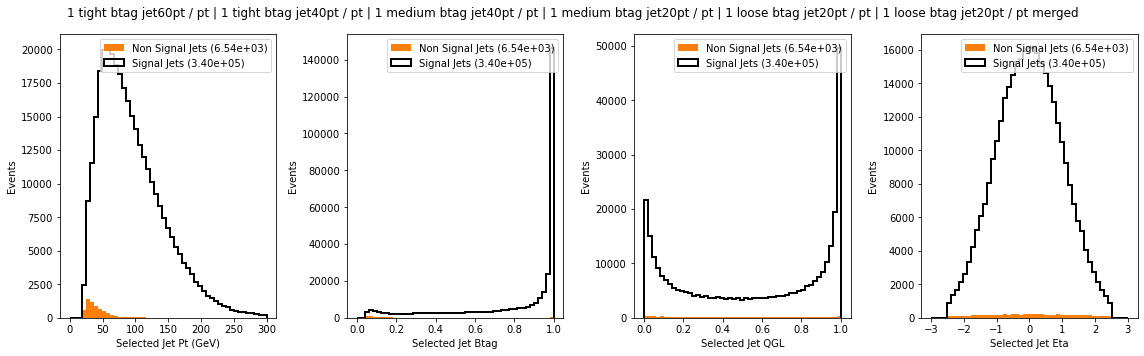

In [45]:
jets_study(final_selection)

--- 1 tight btag jet60pt / pt | 1 tight btag jet40pt / pt | 1 medium btag jet40pt / pt | 1 medium btag jet20pt / pt | 1 medium btag jet20pt / pt | 1 loose btag jet20pt / pt merged ---
Event Efficiency:   0.52
Selected Purity(6): 0.74
Passed Jet S/T:     4.62
Passed Jet MR:      0.06
Passed Jet Eff:     0.54


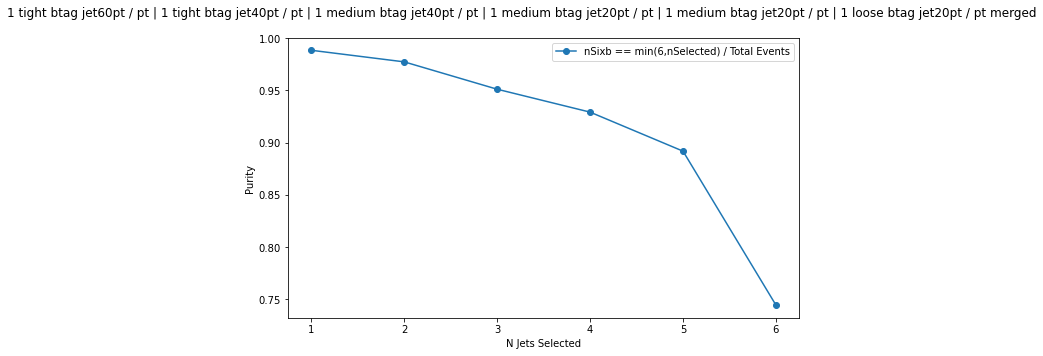

In [34]:
selection_study(final_selection,under6=1,saveas="final_selection")

In [35]:
# x_reco_study(final_selection)